# Processing

In [1]:
import os
import numpy as np
import cv2 as cv
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

First let's load frames saved with an interval given out by the step variable.
Then after loading the images we convert them to grayscale return those too.

In [2]:
def load_frames(game, step = 100):
    """"Function that loads frames with a step given in step parameter 
    giving out images in colorscale and grayscale."""
    pth = f"../imgs/{game}"
    images = os.listdir(pth)
    imgs = []
    gray_imgs = []
    for i in range(0, len(images), step):
        image_path = os.path.join(pth, images[i])
        imgs.append(cv.imread(image_path))
        gray_imgs.append(cv.cvtColor(imgs[len(imgs) - 1], cv.COLOR_BGR2GRAY))
    return imgs, gray_imgs

In [3]:
def show_images(imgs, mode = None):
    """"Function to show multiple images in a compact way."""
    _, ax = plt.subplots(ncols=len(imgs), figsize=(50,18))
    for i in range(len(imgs)):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].grid(False)
        match mode:
            case 'rgb':
                ax[i].imshow(cv.cvtColor(imgs[i], cv.COLOR_BGR2RGB))
            case 'gray':
                ax[i].imshow(imgs[i], cmap='gray')
            case _:
                ax[i].imshow(imgs[i])
        
    plt.tight_layout()

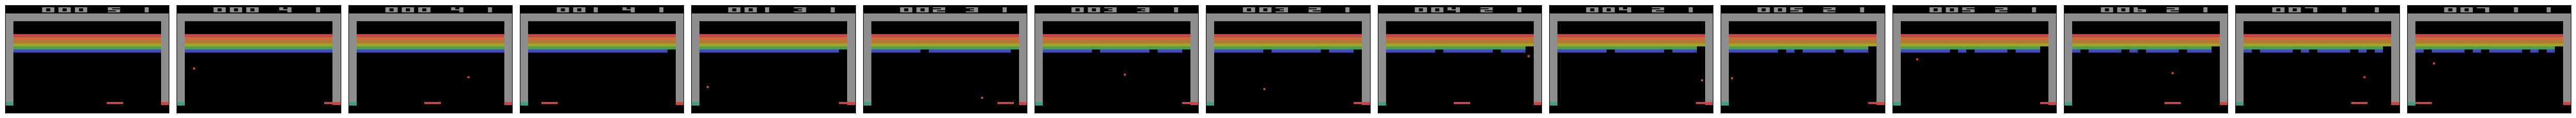

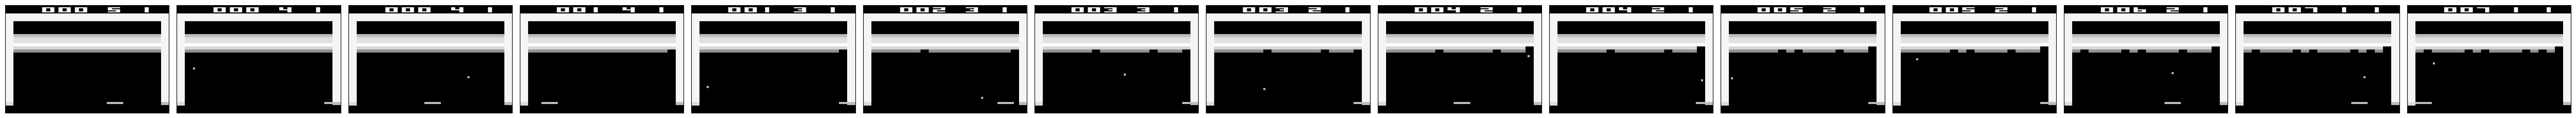

In [4]:
game = 'breakout' # Specify game we want to study
imgs, gray_imgs = load_frames(game, step = 100)

show_images(imgs, mode='rgb')
show_images(gray_imgs, mode='gray')

Now we can start with the proper analisys. The first step is to find keypoints and descriptors.

In [5]:
# Create a SIFT object
sift = cv.SIFT_create()
kps = []
des = []
for g in gray_imgs:
    kp, de = sift.detectAndCompute(g,None)
    kps.append(kp)
    des.append(de)
kp_imgs = []
for i in range(len(kps)):
    kp_imgs.append(cv.drawKeypoints(gray_imgs[i], kps[i], imgs[i].copy(), flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

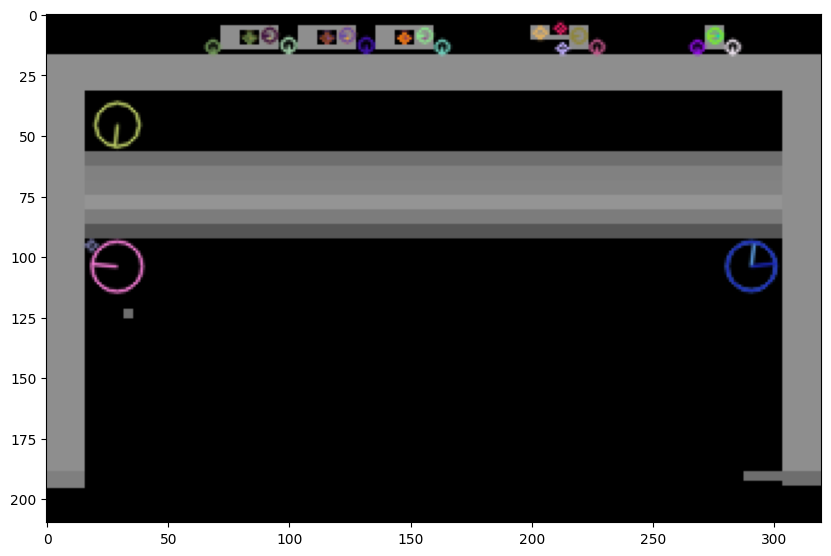

In [6]:
#show_images(kp_imgs, mode='rgb')
plt.imshow(cv.cvtColor(kp_imgs[1], cv.COLOR_BGR2RGB))

Now that we have computed keypoints and descriptors we can find matches between successive frames.

In [7]:
def matchFrames(im1, im2, kp1, kp2, de1, de2, MIN_MATCH_COUNT = 10):
    """"Function to find matches between two successive frames"""
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    flann = cv.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(de1, de2, k = 2)
    
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1, 1, 2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1, 1, 2)
    
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
    
        h,w = im1.shape
        pts = np.float32([ [0, 0], [0, h - 1], [w - 1, h - 1],[w - 1, 0] ]).reshape(-1, 1, 2)
        dst = cv.perspectiveTransform(pts, M)
    
        im2 = cv.polylines(im2, [np.int32(dst)], True, 255, 3, cv.LINE_AA)
    
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None

    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = None,
                    matchesMask = matchesMask, # draw only inliers
                    flags = 2)
    
    im3 = cv.drawMatches(im1,kp1,im2,kp2,good,None,**draw_params)

    return good, im3

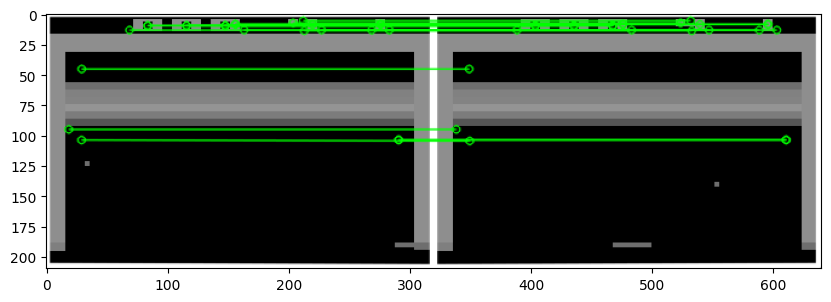

In [8]:
good_matches = []
matched_images = []
for i in range(len(des) - 1):
    gd, im3 = matchFrames(gray_imgs[i], gray_imgs[i + 1], kps[i], kps[i + 1], des[i], des[i + 1])
    good_matches.append(gd)
    matched_images.append(im3)

#show_images(matched_images, mode='rgb')
plt.imshow(cv.cvtColor(matched_images[1], cv.COLOR_BGR2RGB))

After having found some matches between frames we can segment the frames in connected components.

In [9]:
thresholded = []
for i in gray_imgs: # see this again for better division of cc
    _, thresh = cv.threshold(i, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
    thresholded.append(thresh)

num_labels = []
labels = []
stats = []
centroids = []
for t in thresholded:
    output = cv.connectedComponentsWithStats(t, 4, cv.CV_32S)
    num_labels.append(output[0])
    labels.append(output[1])
    stats.append(output[2])
    centroids.append(output[3])


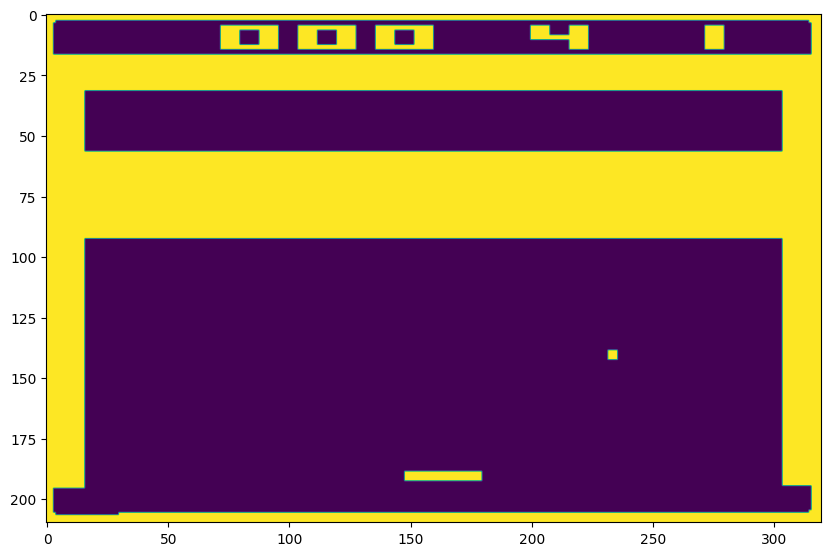

In [10]:
#show_images(thresholded)    
#show_images(labels)

plt.imshow(thresholded[2])

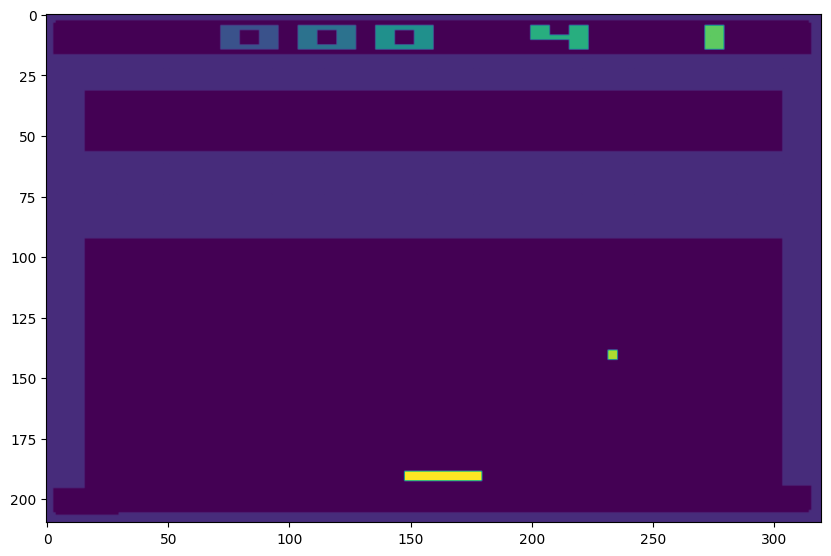

In [11]:
plt.imshow(labels[2])

Now we have collected lost of data on the connected components in the frames.
We can see that some cc are the background of the game.

In [12]:
# Iterating through to show info
for i in range(len(gray_imgs)): # Iterate through frames
    print(f"Frame #{i + 1}")
    for j in range(num_labels[i]):
        text = "examining component {}/{}".format( j + 1, num_labels[i])
        print("[INFO] {}".format(text))
        x = stats[i][j, cv.CC_STAT_LEFT]
        y = stats[i][j, cv.CC_STAT_TOP]
        w = stats[i][j, cv.CC_STAT_WIDTH]
        h = stats[i][j, cv.CC_STAT_HEIGHT]
        area = stats[i][j, cv.CC_STAT_AREA]
        (cX, cY) = centroids[i][j]
        print(x, y, w, h, area, cX, cY)


Frame #1
[INFO] examining component 1/8
0 0 320 210 45840 159.55305410122165 120.2
[INFO] examining component 2/8
72 5 24 10 192 83.5 9.5
[INFO] examining component 3/8
104 5 24 10 192 115.5 9.5
[INFO] examining component 4/8
136 5 24 10 192 147.5 9.5
[INFO] examining component 5/8
200 5 24 10 176 211.5 9.5
[INFO] examining component 6/8
272 5 8 10 80 275.5 9.5
[INFO] examining component 7/8
0 17 320 179 20400 159.38078431372548 72.55607843137255
[INFO] examining component 8/8
198 189 32 4 128 213.5 190.5
Frame #2
[INFO] examining component 1/8
3 3 314 204 43556 159.67134263936083 120.43704656074938
[INFO] examining component 2/8
0 0 320 210 22828 159.625854214123 77.41212545996144
[INFO] examining component 3/8
72 5 24 10 192 83.5 9.5
[INFO] examining component 4/8
104 5 24 10 192 115.5 9.5
[INFO] examining component 5/8
136 5 24 10 192 147.5 9.5
[INFO] examining component 6/8
200 5 24 10 144 213.27777777777777 8.833333333333334
[INFO] examining component 7/8
272 5 8 10 80 275.5 9.5
[

Observe that from frame #2 we have a new cc since the ball has been added to the game.
Also sometimes the bar is colliding with the left wall and we lose its location.
Let's see what the found cc are in the game:

#1 is the blue background that includes the numbers of the score.
#2
#3
#4
#8
#9

In [13]:
# Let's now draw rectangles around cc
drawn_cc = []
for i in imgs:
    drawn_cc.append(i.copy())

for i in range(len(drawn_cc)): # Iterate through frames
    for j in range(num_labels[i]):
        if i == 0:
            if j != 0 and j != 6: # ignore background component 0 and a left component 1
                x = stats[i][j, cv.CC_STAT_LEFT]
                y = stats[i][j, cv.CC_STAT_TOP]
                w = stats[i][j, cv.CC_STAT_WIDTH]
                h = stats[i][j, cv.CC_STAT_HEIGHT]
                cv.rectangle(drawn_cc[i], (x, y), (x + w, y + h), (0,255,0), 1)
        else:
            if j != 0 and j != 1: # ignore background component 0 and a left component 1
                x = stats[i][j, cv.CC_STAT_LEFT]
                y = stats[i][j, cv.CC_STAT_TOP]
                w = stats[i][j, cv.CC_STAT_WIDTH]
                h = stats[i][j, cv.CC_STAT_HEIGHT]
                cv.rectangle(drawn_cc[i], (x, y), (x + w, y + h), (0,255,0), 1)



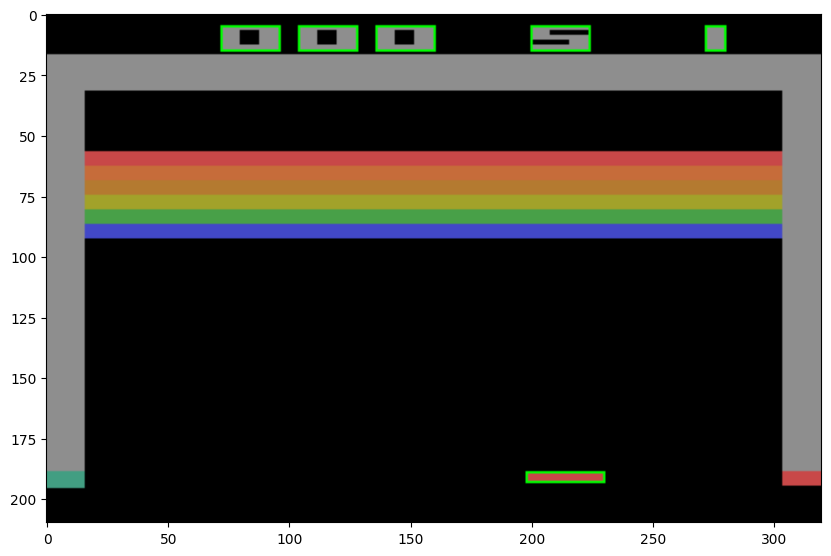

In [17]:
#show_images(drawn_cc, mode='rgb')
plt.imshow(cv.cvtColor(drawn_cc[0], cv.COLOR_BGR2RGB));

The current objective is now to define each cc as mobile or not and then track Its movements.
For classification get all pixels of an object in every frame and check if they are maintained in the next.
For tracking check centrometer of object to track movements.

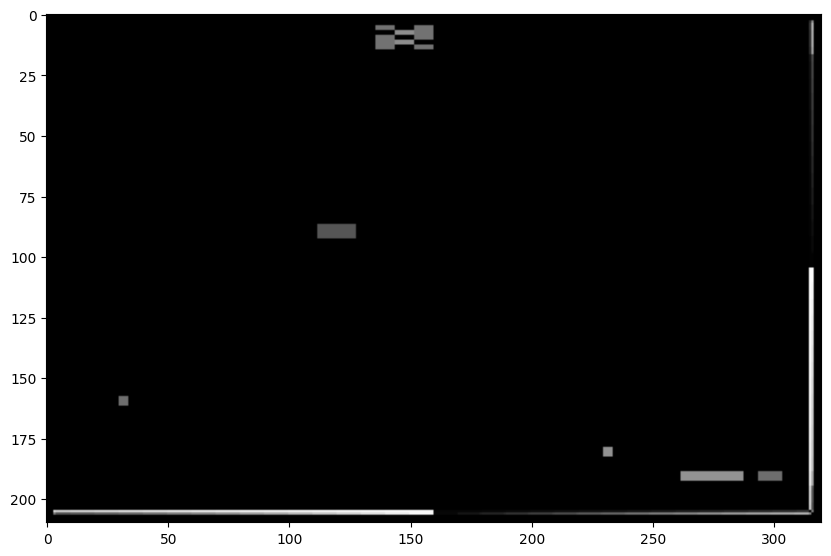

In [15]:
diff = []
for i in range(len(gray_imgs) - 1):
    diff.append(gray_imgs[i] - gray_imgs[i + 1])
plt.imshow(cv.cvtColor(diff[4], cv.COLOR_BGR2RGB));